<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #7: Ranking

<span style="color:blue; font-size: 12pt">Anastasia Zukhba </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Check Questions (10%)</h1> 

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

Пара запрос-документ; релевантность документа к данному запросу; только документы, полученные по одному запросу.

**2.** В чём преимущество метрики NDCG перед метрикой MAP?

Функция ранжирования может принимать не только бинарные, но и вещественные значения.

**3.** Почему говорят, что все основные метрики качества дискретны?

Потому что они основаны на числе инверсий, коих конечное количество для наперед заданного $n$

**4.** В чем преимущество факторизации в модели RankNet?

<Ответ>

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

<Ответ>

**6.** Какое преобразование данных используется в модели RankSVM?

<Ответ>

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

<Ответ>

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

<Ответ>

<h1 align="center"> Theoretical tasks (10%)</h1>

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

<Решение>

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

<Решение>

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

<Решение>

<h1 align="center"> Practical tasks (80%)</h1>
# Part 1 (15%)

In [1]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('text', usetex=False)
plt.rc('text.latex', unicode=True)
plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
plt.rc('font', family='serif', size='16')

## Вычисление весов PageRank power-методом.

Реализовать удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [6]:
from scipy.linalg import norm
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
        
    link_list = [[] for _ in range(N)]
    for link in links:
        link_list[link[0]].append(link[1])
 
    prob_matrix = np.ones((N, N)) / N
    for u, neighbours in (enumerate(link_list)):
        if neighbours:
            prob_matrix[u] *= damping_factor
            for v in neighbours:
                prob_matrix[u][v] += (1. - damping_factor) / len(neighbours)
    
    return np.matrix(prob_matrix)


def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    prob_matrix = create_page_rank_markov_chain(links, 
                                                damping_factor=damping_factor)
    distribution = np.matrix(start_distribution)
    
    prev, curr = distribution, np.dot(distribution, prob_matrix) 
    trace = [prev]
    while norm(curr - prev) > tolerance:
        prev, curr = curr, np.dot(curr, prob_matrix)
        trace.append(prev)
    
    
    
    if return_trace:
        return np.array(np.matrix(curr)).ravel(), np.array(trace)
    else:
        return np.array(np.matrix(curr)).ravel()

# Проверка реализации
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [7]:
def random_graph(n, p):
    return np.array([(u, v) for u in range(n) for v in range(n) if np.random.rand() < p])

Теперь сгенерируем случайный граф и нарисуем его.

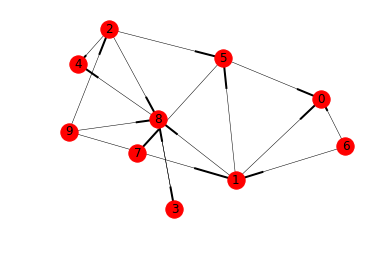

In [8]:
N, p = 10, 0.2
edges = random_graph(N, p)

G = networkx.DiGraph()
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

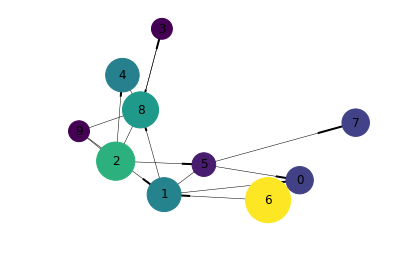

In [9]:
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(edges, start_distribution)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

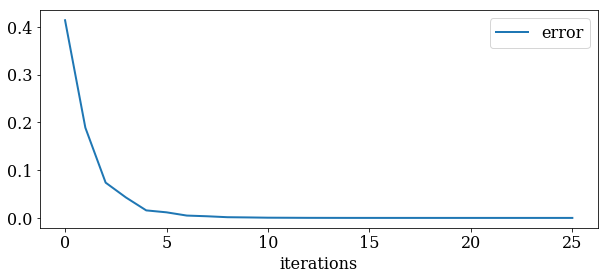

In [10]:
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
# plt.plot(x, <верхняя оценка скорости сходимости из эргодической теоремы>, 
#          lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

<Выводы>

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

<Исследования и выводы>

# Part 2 (15%)

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [44]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [45]:
urls = ['http://wikipedia.org/wiki/']
site = get_site(urls[0])
links = []

N = 10
for i in range(N):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(links_from_url[j])))
            
            # Новая ссылка
            else:
                links.append((i, len(urls)))
                urls.append(links_from_url[j])
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

## Part 3 (50%)

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [ ]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines])))
        values.append(block_values)
        text = text[index:]
        
    return values

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

In [ ]:
values = (read_metric_dependence_from_file('... log_LambdaMART', 300)[0],
          read_metric_dependence_from_file('... log_MART', 300)[0])

plt.figure(figsize=(20, 8))
plt.plot(<x>, <y>, lw=2, label=<...>)
<...>
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title(<...>)
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

<Ответ>

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

In [ ]:
<...>

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ>

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [ ]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

Если код выше не работает, воспользуйтесь следующей функцией.

In [ ]:
import subprocess

def _run_cmd(cmd, print=False):
    """ Запуск консольной команды cmd """
    
    PIPE = subprocess.PIPE
    p = subprocess.Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE,
                         stderr=subprocess.STDOUT, close_fds=True)
    output = ''
    
    while True:
        s = p.stdout.readline().decode('utf-8')
        if not s: break
        output += str(s)
        if print:
            print(s)
    
    return output